<a href="https://colab.research.google.com/github/tsaiiuo/cyberbullyingDetectRNN/blob/main/%E7%B6%B2%E8%B7%AF%E9%9C%B8%E5%87%8C%E5%88%86%E9%A1%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Cyberbullying Classification

*   流程：讀取資料 => 資料清理 => TF-IDF加權 => 訓練model




In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization
import tensorflow as tf

# Import data


*   47692筆資料




In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/JustinLien0805/cyberBullyingCSV/main/cyberbullying_tweets.csv')  # Importing the dataset

In [ ]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [ ]:
!pip install demoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 278 kB/s 


# Clean Text

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import demoji
import string
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [ ]:
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.update(['rt', 'mkr', 'didn', 'bc', 'n', 'm', 
                  'im', 'll', 'y', 've', 'u', 'ur', 'don', 
                  'p', 't', 's', 'aren', 'kp', 'o', 'kat', 
                  'de', 're', 'amp', 'will', 'wa', 'e', 'like'])
stemmer = SnowballStemmer('english')
def clean_text(text): # Clean Text
    
    # Removing Hashtag, Mention, URLs
    pattern = re.compile(r"(#[A-Za-z0-9]+|@[A-Za-z0-9]+|https?://\S+|www\.\S+|\S+\.[a-z]+|RT @)")
    text = pattern.sub('', text)
    text = " ".join(text.split())
    
    # lowercase
    text = text.lower()
    
    # Stemming
    text = " ".join([stemmer.stem(word) for word in text.split()])
    
    # Removing Punctuations
    remove_punc = re.compile(r"[%s]" % re.escape(string.punctuation))
    text = remove_punc.sub('', text)
    
    # Removing stopwords
    text = " ".join([word for word in str(text).split() if word not in STOPWORDS])
    
    # Taking care of emojis
    emoji = demoji.findall(text)
    for emot in emoji:
        text = re.sub(r"(%s)" % (emot), "_".join(emoji[emot].split()), text)

    return text

In [ ]:
df['cleaned_text'] = df['tweet_text'].apply(lambda text: clean_text(text))  # Applying the cleaning to the text data

In [ ]:
df.head()

,tweet_text,cyberbullying_type,cleaned_text
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word food crapilicious
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,whi white
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classi whore red velvet cupcakes
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,gio meh thank head concern anoth angri dude tw...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretend kurdish account islam lies


In [ ]:
df.isnull().sum()  # Checking for missing values

tweet_text            0
cyberbullying_type    0
cleaned_text          0
dtype: int64

In [ ]:
df['cleaned_text'].duplicated().sum() # Checking for duplicate values

2887

In [ ]:
df.drop_duplicates("cleaned_text", inplace = True) # clean duplicate value

In [ ]:
df['cleaned_text'].str.isspace().sum() # Checking for tweets with only whitespaces

0

In [ ]:
df = df[df["cyberbullying_type"]!="other_cyberbullying"]

In [ ]:
df['cyberbullying_type'].value_counts()

religion             7946
age                  7887
ethnicity            7797
not_cyberbullying    7670
gender               7637
Name: cyberbullying_type, dtype: int64

In [ ]:
df['cleaned_text']

0                                   word food crapilicious
1                                                whi white
2                         classi whore red velvet cupcakes
3        gio meh thank head concern anoth angri dude tw...
4           isi account pretend kurdish account islam lies
                               ...                        
47687    black ppl arent expect anything depend anythin...
47688    turner withhold disappointment turner call cou...
47689    swear god dumb nigger bitch got bleach hair re...
47690    yea fuck therealexel nigger fuck unfollow fuck...
47691    bro gotta chill chillshrammy dog fuck dumb nig...
Name: cleaned_text, Length: 38937, dtype: object

# 用TF-IDF做加權(TF*IDF)


*   tf 詞頻（term frequency，TF(t,d)): number of times term(t) appear in the doc(d)
*   idf 逆向文件頻率（inverse document frequency，IDF(d): log(number of doc/number of doc term(t) appear)









In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
X = df['cleaned_text']  # Feature (raw data)
y = df['cyberbullying_type']  # Target Label

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) # 將資料分為test, train

In [ ]:
tfidf = TfidfVectorizer(max_features = 5000)  # TF - IDF Vectorizer 抓出 top 5000 特徵

In [ ]:
# Feature Extraction
X_train_tfidf = tfidf.fit_transform(X_train)  # 轉為 sparse matrix
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler() 
tfidf_array_train = X_train_tfidf.toarray()   # sparse matrix to a numpy array 
tfidf_array_test = X_test_tfidf.toarray()     

In [ ]:
print(f"Feature name: {tfidf.get_feature_names()}") 
print(f"TF-IDF result: {tfidf.idf_}")
print("\n")
pd.DataFrame(tfidf_array_train)

Feature name: ['10', '100', '1000', '10000', '1010', '10th', '10x', '11', '110', '12', '13', '14', '140', '1400', '15', '150', '16', '17', '18', '19', '1947', '1990', '1994', '1d', '1st', '20', '200', '2000', '2000s', '2001', '2007', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '20th', '21', '21st', '22', '23', '24', '247', '25', '26', '2611', '28', '29', '2gether', '2nd', '30', '300', '32', '33', '3333', '34', '35', '3rd', '40', '400', '411pain', '45', '4m', '4th', '50', '500', '55', '56', '5sos', '5th', '60', '600', '6th', '70', '72', '7th', '80', '800', '80s', '8th', '90', '90s', '911', '95', '98', '99', '9th', 'aa', 'ab', 'abandon', 'abdul', 'abe', 'abil', 'abl', 'ableist', 'abolish', 'abort', 'abortion', 'abov', 'abroad', 'absolut', 'absolutely', 'absurd', 'abt', 'abu', 'abus', 'abuse', 'acc', 'accept', 'acceptable', 'access', 'accident', 'accomplish', 'accord', 'account', 'accountable', 'acct', 'accur', 'accus', 'achiev', 'acho', 'acknow

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
scaled_X_train = scaler.fit_transform(tfidf_array_train)  # 轉為常態分佈, mean => 0, stddev => 1
scaled_X_test = scaler.transform(tfidf_array_test) 

In [ ]:
print(np.info(scaled_X_train))
pd.DataFrame(scaled_X_train)

class:  ndarray
shape:  (31149, 5000)
strides:  (40000, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x127a96000
byteorder:  little
byteswap:  False
type: float64
None


,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,-0.058045,-0.062036,-0.027422,-0.015297,-0.013396,-0.01551,-0.01672,-0.034849,-0.025651,-0.053143,...,-0.01457,-0.026566,-0.01464,-0.014464,-0.017625,-0.040924,-0.014816,-0.021896,-0.017303,-0.017777
1,-0.058045,-0.062036,-0.027422,-0.015297,-0.013396,-0.01551,-0.01672,-0.034849,-0.025651,-0.053143,...,-0.01457,-0.026566,-0.01464,-0.014464,-0.017625,-0.040924,-0.014816,-0.021896,-0.017303,-0.017777
2,-0.058045,-0.062036,-0.027422,-0.015297,-0.013396,-0.01551,-0.01672,-0.034849,-0.025651,-0.053143,...,-0.01457,-0.026566,-0.01464,-0.014464,-0.017625,-0.040924,-0.014816,-0.021896,-0.017303,-0.017777
3,-0.058045,-0.062036,-0.027422,-0.015297,-0.013396,-0.01551,-0.01672,-0.034849,-0.025651,-0.053143,...,-0.01457,-0.026566,-0.01464,-0.014464,-0.017625,-0.040924,-0.014816,-0.021896,-0.017303,-0.017777
4,-0.058045,-0.062036,-0.027422,-0.015297,-0.013396,-0.01551,-0.01672,-0.034849,-0.025651,-0.053143,...,-0.01457,-0.026566,-0.01464,-0.014464,-0.017625,-0.040924,-0.014816,-0.021896,-0.017303,-0.017777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31144,-0.058045,-0.062036,-0.027422,-0.015297,-0.013396,-0.01551,-0.01672,-0.034849,-0.025651,-0.053143,...,-0.01457,-0.026566,-0.01464,-0.014464,-0.017625,-0.040924,-0.014816,-0.021896,-0.017303,-0.017777
31145,-0.058045,-0.062036,-0.027422,-0.015297,-0.013396,-0.01551,-0.01672,-0.034849,-0.025651,-0.053143,...,-0.01457,-0.026566,-0.01464,-0.014464,-0.017625,-0.040924,-0.014816,-0.021896,-0.017303,-0.017777
31146,-0.058045,-0.062036,-0.027422,-0.015297,-0.013396,-0.01551,-0.01672,-0.034849,-0.025651,-0.053143,...,-0.01457,-0.026566,-0.01464,-0.014464,-0.017625,-0.040924,-0.014816,-0.021896,-0.017303,-0.017777
31147,-0.058045,-0.062036,-0.027422,-0.015297,-0.013396,-0.01551,-0.01672,-0.034849,-0.025651,-0.053143,...,-0.01457,-0.026566,-0.01464,-0.014464,-0.017625,-0.040924,-0.014816,-0.021896,-0.017303,-0.017777


# Model Training


In [ ]:
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [ ]:
# Neural Networks
from sklearn.neural_network import MLPClassifier
nn_model = MLPClassifier(hidden_layer_sizes=(100), activation = 'logistic', max_iter = 15)  # Sigmoid Activation Function, epoch=15, hidden layer =100
# 用halvinggridsearchCV(自動調整參數) 
param_grid = {'learning_rate_init': [0.001, 0.0015, 0.002]} # 設定參數
grid_nn_model = HalvingGridSearchCV(nn_model, param_grid = param_grid, n_jobs=-1)
grid_nn_model.fit(X_train_tfidf, y_train) # 評估模型準確度

HalvingGridSearchCV(estimator=MLPClassifier(activation='logistic',
                                            hidden_layer_sizes=100,
                                            max_iter=15),
                    n_jobs=-1,
                    param_grid={'learning_rate_init': [0.001, 0.0015, 0.002]})

最佳準確率: 0.9048230593607306，最佳參數組合：{'learning_rate_init': 0.0015} 

                   precision    recall  f1-score   support

              age       0.96      0.95      0.96       810
        ethnicity       0.97      0.97      0.97       760
           gender       0.88      0.85      0.87       790
not_cyberbullying       0.78      0.82      0.80       783
         religion       0.94      0.93      0.94       751

         accuracy                           0.91      3894
        macro avg       0.91      0.91      0.91      3894
     weighted avg       0.91      0.91      0.91      3894



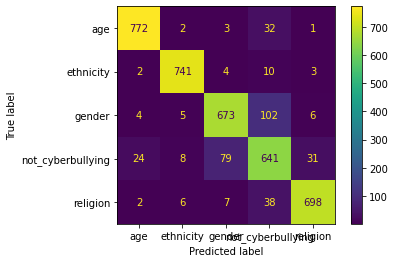

In [ ]:
# result
print(f"最佳準確率: {grid_nn_model.best_score_}，最佳參數組合：{grid_nn_model.best_params_} \n") # 找到最佳的參數
preds_grid_nn_model = grid_nn_model.predict(X_test_tfidf) # 使用模型進行預測
print(classification_report(y_test, preds_grid_nn_model)) # 比較預測和實際結果差異
plot_confusion_matrix(grid_nn_model, X_test_tfidf, y_test) # 顯示於confusion matrix

# Pipeline Creation

In [ ]:
# Creating a pipeline
from sklearn.pipeline import Pipeline
# combine all the previous steps: tfidf and model training
pipe = Pipeline([('tfidf', TfidfVectorizer(max_features = 5000)), ('nn', MLPClassifier())])
pipe.fit(X, y) # all data from df[clean_text] and df[cyberbullying type]
pipe.score(X,y)

0.9977399388756196

# Gradio


In [ ]:
!pip install Gradio

In [ ]:
import gradio as gr

In [ ]:
def result(text):
  res = pipe.predict([text])
  return res[0]
inputs = gr.Textbox()
# create gradio app
app = gr.Interface(fn=result, inputs=inputs, outputs="text", title="cyberbullying classification")
app.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://20861.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<gradio.routes.App at 0x7fe29c0f22d0>,
 'http://127.0.0.1:7861/',
 'https://20861.gradio.app')